# Regression & Model Assessment

Regression is supervised learning with continuous (or sometimes discrete) labels. You are given labeled data consisting of features and labels $\{\vec{x}_i, y_i\}$. The goal is to find a function that describes their relationship, $\hat{f}(\vec{x}) = \hat{y}$.

## Objectives

After completing this notebook, you should be able to:

- Perform multi-dimensional regression with a loss function using PyTorch
- Understand train/test splitting and why we batch
- Reason about model bias and model variance
- Assess model fit and generalization error using cross-validation
- Apply L1 and L2 regularization

## Prerequisites

- Expectation: $E[x] = \sum P(x)x$, variance: $E[(x - E[x])^2]$
- Basic linear regression concepts
- Familiarity with PyTorch tensors

## Dependencies

This notebook uses **only PyTorch** (plus standard library: `matplotlib`, `pandas`, `numpy` for data loading and plotting). All model fitting and gradient computation is done through PyTorch.

## Setup & Data Loading

We start with three standard imports:

- **`torch`** — PyTorch, our sole ML framework. Provides tensors, automatic differentiation, and optimizers.
- **`pandas`** — For loading and slicing tabular data (CSV files). We convert to PyTorch tensors before any ML work.
- **`matplotlib.pyplot`** — Plotting.

The dataset is **AqSolDB** (Sorkun et al., 2019): ~10,000 unique compounds with measured aqueous solubility (label) and 17 molecular descriptors (features). It's hosted as a CSV on GitHub and can be read directly via URL with `pd.read_csv()`.

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# load data directly from GitHub
url = "https://github.com/whitead/dmol-book/raw/main/data/curated-solubility-dataset.csv"
soldata = pd.read_csv(url)
soldata.head()


,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...,SZEMGTQCPRNXEG-UHFFFAOYSA-M,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,0.0,1,G1,392.510,...,17.0,142.0,0.0,0.0,0.0,0.0,0.00,158.520601,0.000000e+00,210.377334
1,A-4,Benzo[cd]indol-2(1H)-one,InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767,0.0,1,G1,169.183,...,0.0,62.0,2.0,0.0,1.0,3.0,29.10,75.183563,2.582996e+00,511.229248
2,A-5,4-chlorobenzaldehyde,InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078,0.0,1,G1,140.569,...,1.0,46.0,1.0,0.0,0.0,1.0,17.07,58.261134,3.009782e+00,202.661065
3,A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",InChI=1S/2C23H22O3.Zn/c2*1-15(17-9-5-3-6-10-17...,XTUPUYCJWKHGSW-UHFFFAOYSA-L,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,0.0,1,G1,756.226,...,10.0,264.0,6.0,0.0,0.0,6.0,120.72,323.755434,2.322963e-07,1964.648666
4,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,InChI=1S/C25H30N2O4/c1-5-20(26(10-22-14-28-22)...,FAUAZXVRLVIARB-UHFFFAOYSA-N,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,0.0,1,G1,422.525,...,12.0,164.0,2.0,4.0,4.0,6.0,56.60,183.183268,1.084427e+00,769.899934


In [3]:
# print column names to  see which features we can use
print(soldata.columns)

Index(['ID', 'Name', 'InChI', 'InChIKey', 'SMILES', 'Solubility', 'SD',
       'Ocurrences', 'Group', 'MolWt', 'MolLogP', 'MolMR', 'HeavyAtomCount',
       'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds',
       'NumValenceElectrons', 'NumAromaticRings', 'NumSaturatedRings',
       'NumAliphaticRings', 'RingCount', 'TPSA', 'LabuteASA', 'BalabanJ',
       'BertzCT'],
      dtype='object')


In [7]:
# It seems that the physico-chemical properties are the most relevant here as features. Let's collect them in a list. 
feature_cols = [
  'MolWt', 'MolLogP', 'MolMR', 'HeavyAtomCount',
  'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds',
  'NumValenceElectrons', 'NumAromaticRings', 'NumSaturatedRings',
  'NumAliphaticRings', 'RingCount', 'TPSA', 'LabuteASA', 'BalabanJ',
  'BertzCT'
  ]
target_col = 'Solubility'

### Feature Correlation

Before fitting any model, it's worth visually inspecting how each feature correlates with the label (Solubility). Note that there are a few columns unrelated to features or solubility: `SD` (standard deviation), `Ocurrences` (how often the molecule occurred in the constituent databases), and `Group` (where the data came from).

We use `plt.subplots()` to create a grid of scatter plots — one per feature — sharing the y-axis so solubility scales are directly comparable. The `f"C{i}"` format string cycles through matplotlib's default color palette (`C0`, `C1`, ..., `C9`, then repeats).

Number of features: 17
Creating a plot 5 x 4 grid of scatter plots...


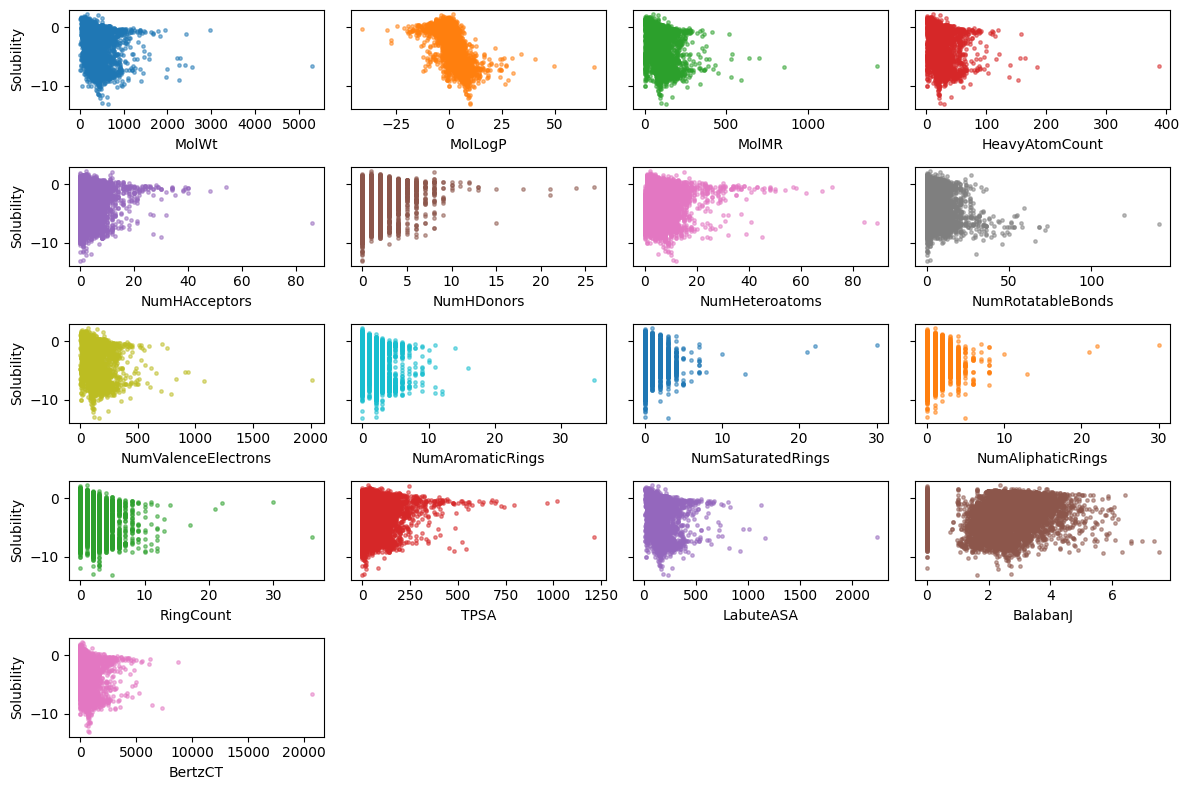

In [14]:
print(f"Number of features: {len(feature_cols)}")
print(f"Creating a plot 5 x 4 grid of scatter plots...")
# create a 5 x 4 grid of scatter plots
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(12, 8), sharey=True)
axs = axes.flatten()
for i, col in enumerate(feature_cols):
    axs[i].scatter(
      soldata[col], soldata[target_col], s=6, alpha=0.5, color=f'C{i}')
    axs[i].set_xlabel(col)
    if i % 4 == 0:
        axs[i].set_ylabel(target_col)
# hide any unused subplots
for j in range(len(feature_cols), len(axs)):
  fig.delaxes(axs[j])
plt.tight_layout()
plt.show()